In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import time
from functions import*

In [2]:
# Define an RBF (Gaussian) Kernel
def rbf_kernel(X1, X2, length_scale=0.1, sigma_f=1.0):
    """Computes the RBF kernel matrix."""
    sq_dist = cdist(X1, X2, 'sqeuclidean')
    return sigma_f ** 2 * np.exp(-sq_dist / (2 * length_scale ** 2))

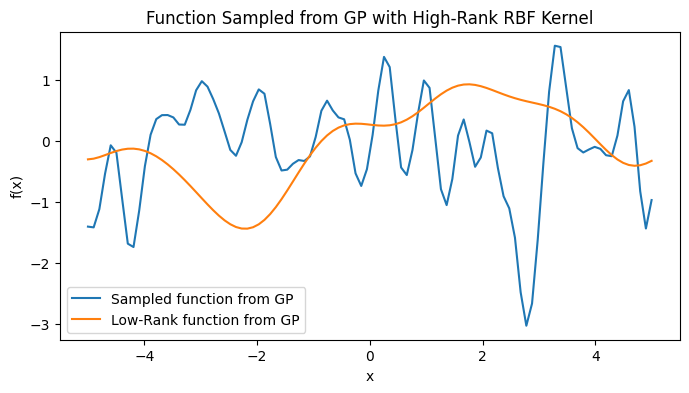

In [3]:
# Generate input points
X = np.linspace(-5, 5, 10**2).reshape(-1, 1)

# Compute kernel matrix (covariance matrix for the GP)
K = rbf_kernel(X, X, length_scale=0.2)
K_low_rank = rbf_kernel(X, X, length_scale=1)

# Sample from a Gaussian Process (mean=0, covariance=K)
f_samples = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K)
f_samples_low_rank = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K_low_rank)

# Plot the sampled function
plt.figure(figsize=(8, 4))
plt.plot(X, f_samples, label="Sampled function from GP")
plt.plot(X, f_samples_low_rank, label="Low-Rank function from GP")
plt.title("Function Sampled from GP with High-Rank RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [ ]:
# Example: create an instance
gp = GPfunctions_noise(K=10, length_scale=1.0)

# Measure runtime of a method
start_time = time.time()
subset = gp.algorithm()
end_time = time.time()
print(f"algorithm() runtime: {end_time - start_time:.4f} seconds")

print(f"algorithm() sample size: {gp.epsilon_samplesize}")

# Measure runtime for ucb_action_selection
start_time = time.time()
ucb_actions = gp.ucb_action_selection(N=3000)
end_time = time.time()
print(f"ucb_action_selection() runtime: {end_time - start_time:.4f} seconds")

# Measure runtime for ts_action_selection
start_time = time.time()
ts_actions = gp.ts_action_selection(N=3000)
end_time = time.time()
print(f"ts_action_selection() runtime: {end_time - start_time:.4f} seconds")


algorithm() runtime: 0.2111 seconds
algorithm() sample size: 3000
ucb_action_selection() runtime: 3.7491 seconds
ts_action_selection() runtime: 0.2845 seconds


In [14]:
K=10
# Create an instance
gp = GPfunctions_noise(K=K, length_scale=1.0)

# Number of repetitions
repetitions = 30

# Store runtimes
runtimes = {
    "epsilon": [],"ts": [],"ucb": [],
}

# Store samplesize
samplesize = {
    "epsilon": [],"ts": [3000*K]*repetitions,
    "ucb": [500+2000*K]*repetitions, # UCB needs initialization
}

for i in range(repetitions):
    # Algorithm
    start_time = time.time()
    subset = gp.algorithm()
    end_time = time.time()
    runtimes["epsilon"].append(end_time - start_time)
    samplesize["epsilon"].append(gp.epsilon_samplesize)
    
    # Thompson Sampling
    start_time = time.time()
    ts_actions = gp.ts_action_selection(N=3000)
    end_time = time.time()
    runtimes["ts"].append(end_time - start_time)

    # UCB
    start_time = time.time()
    ucb_actions = gp.ucb_action_selection(N=3000)
    end_time = time.time()
    runtimes["ucb"].append(end_time - start_time)
    
# Convert to numpy array if you want easy statistics
runtimes_array = {k: np.array(v) for k, v in runtimes.items()}
samplesize_array = {k: np.array(v) for k, v in samplesize.items()}

# Print results
for key, times in runtimes_array.items():
    print(f"{key}: mean={times.mean():.4f}s, std={times.std():.4f}s, all={times}")

epsilon: mean=0.1895s, std=0.0248s, all=[0.18073153 0.17498565 0.17938685 0.18452644 0.17951679 0.17738128
 0.1836803  0.24547458 0.17547917 0.18056655 0.2483573  0.17786551
 0.17696786 0.18604708 0.17471051 0.17565608 0.17673683 0.21664619
 0.176687   0.17482066 0.27409577 0.19620252 0.17461801 0.19625974
 0.21496797 0.17792058 0.17640305 0.17565036 0.17669606 0.1764183 ]
ts: mean=0.2894s, std=0.0168s, all=[0.27662849 0.2804091  0.31487966 0.2922709  0.31943965 0.31736827
 0.30671    0.28782749 0.27510238 0.27882576 0.27530003 0.2739265
 0.29588532 0.30008674 0.27359796 0.27379775 0.2723968  0.28892207
 0.30016923 0.27439713 0.31189585 0.29991174 0.31985307 0.27130079
 0.27567101 0.28966022 0.31579232 0.27078247 0.27826262 0.27098012]
ucb: mean=3.7805s, std=0.1130s, all=[3.99439931 3.911093   3.96323037 3.64916611 3.63222599 3.79798484
 4.11078763 3.83480668 3.7151165  3.86841893 3.84280586 3.70407534
 3.73060822 3.6714232  3.79415607 3.75030732 3.64716887 3.7579062
 3.72133875 3.8322

In [15]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.5,1,1.5,2,3,4]
K=10
for length_scale in length_range:
    for ignore in range(30):
        fun=GPfunctions_noise(K,length_scale=length_scale,IfStationary=IfStationary)
        output=fun.test(fun.subset)
        ucb=fun.test(fun.ucb_action_selection(N=3000))
        ts=fun.test(fun.ts_action_selection(N=3000))
        row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
        row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
        row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
        report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

# report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

In [18]:
report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

**Plots**

In [19]:
report=pd.read_csv('report_StationaryTrue.csv')
length_range=[0.5,1,1.5,2,3,4]
K=10

In [20]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts in PDF
mpl.rcParams['ps.fonttype'] = 42   # Use TrueType fonts in PS
plt.rcParams.update({'font.size': 14})

methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet+TS','Combinatorial TS','Combinatorial UCB']))
legendnames = dict(zip(methods,['EpsilonNet+TS (N=300)','Combinatorial TS (N=3000)','Combinatorial UCB (N=2000)']))
colormap = dict(zip(methods, ["#76ad1f","#E19107FF",'#ff595e'])) #['b',"#B87502FF","#F45106E7"]

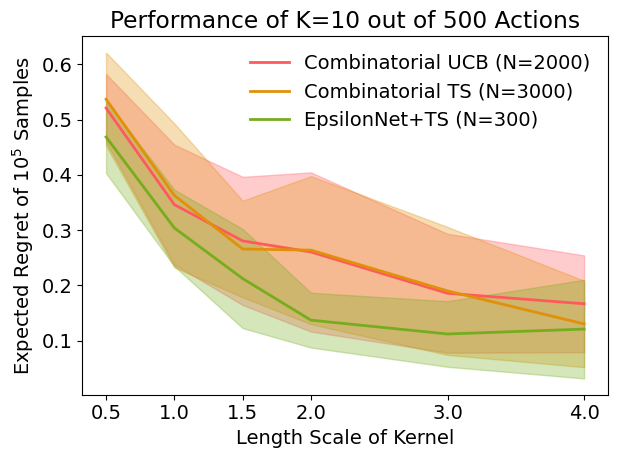

In [22]:
fig, axes = plt.subplots()  # (rows, cols)

for m in methods[::-1]:
    dfmean=report.groupby(by=["length_scale",'method']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[l][m] for l in length_range])
    dfstd=report.groupby(by=["length_scale",'method']).std()['EmpiricialRegret']
    std=np.array([dfstd[l][m] for l in length_range])
    axes.plot(length_range, mean, label="{}".format(legendnames[m]), color=colormap[m],linewidth=2)
    axes.fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.3)

# axes[i].set_ylim([0,0.7])
axes.set_title("Performance of K={} out of 500 Actions".format(K))
axes.set_xlabel("Length Scale of Kernel")
axes.set_xticks(length_range)
axes.set_ylabel(r"Expected Regret of $10^5$ Samples")
axes.legend(framealpha=0)

# Save plot as a PDF without margins
plt.savefig("RKHS_combinatorial.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

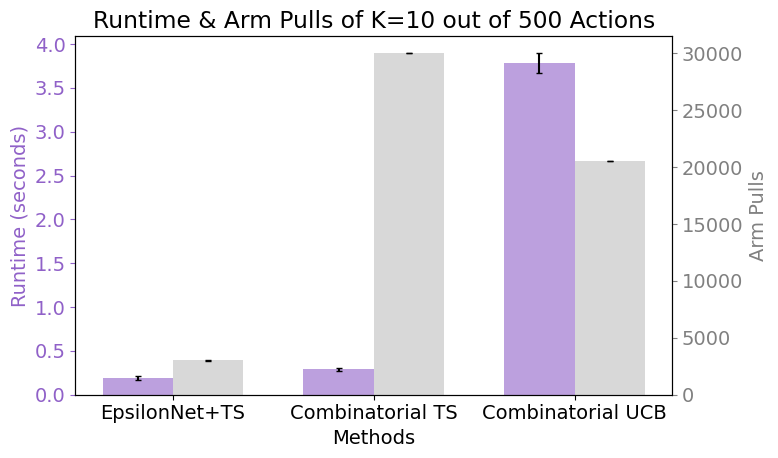

In [23]:
fig, ax1 = plt.subplots(figsize=(8, 4.8)) 

runtime_color = "#9061C8FF"
samplesize_color = "gray"

functions = list(runtimes_array.keys())
x = np.arange(len(functions))   # positions on x-axis
width = 0.35                    # width of each bar

# Runtime means & stds
means_runtime = [runtimes_array[f].mean() for f in functions]
stds_runtime = [runtimes_array[f].std() for f in functions]

# Sample size means & stds
means_samples = [samplesize_array[f].mean() for f in functions]
stds_samples = [samplesize_array[f].std() for f in functions]

# Bar positions: shift runtime left, sample size right
bars1 = ax1.bar(
    x - width/2,
    means_runtime,
    yerr=stds_runtime,
    capsize=2,
    color=runtime_color,
    alpha=0.6,
    width=width
)

ax1.set_xlabel("Methods", color='black')
ax1.set_ylabel("Runtime (seconds)", color=runtime_color)
ax1.tick_params(axis='y', colors=runtime_color)   # y-axis tick color
ax1.set_title(f"Runtime & Arm Pulls of K={K} out of 500 Actions")

# Second axis for sample sizes
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    means_samples,
    yerr=stds_samples,
    capsize=2,
    alpha=0.3,
    color=samplesize_color,
    width=width
)
ax2.set_ylabel("Arm Pulls", color=samplesize_color)
ax2.tick_params(axis='y', colors=samplesize_color)  # y-axis tick color

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels([methodnames[f] for f in functions])

# Save plot as a PDF without margins
plt.savefig("RKHS_runtime.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()
